I am practicing on what Kandrani has made for feature extractions.
I found that he is normalizing some values and leaving some values.
for example:
`avg_lane_angle` could be normalized by dividing it by pi
```python
avg_lane_angle/np.pi
```
the `speed` could also be normalized. After running some tests to find the maximum speed, I got the highest value of `98.5061956708646` as speed. So I am going to assume the maximum speed is 100. For safety we are going to take the minium in case the speed could be higher (1.02), it will be maxed to 1.
```python
min(speed/100.0,1.0)
```

[Episode 0] Total reward: -75.95
[Episode 1] Total reward: -74.94
[Episode 2] Total reward: -67.66
[Episode 3] Total reward: -79.67
[Episode 4] Total reward: -143.70
[Episode 5] Total reward: -82.18
[Episode 6] Total reward: -71.74
[Episode 7] Total reward: -84.09
[Episode 8] Total reward: -27.84
[Episode 9] Total reward: -77.27
[Episode 10] Total reward: -8.91
[Episode 11] Total reward: -19.66
[Episode 12] Total reward: -69.60
[Episode 13] Total reward: -53.49
[Episode 14] Total reward: -74.59
[Episode 15] Total reward: -76.48
[Episode 16] Total reward: -71.65
[Episode 17] Total reward: -76.13
[Episode 18] Total reward: -119.42
[Episode 19] Total reward: -67.88
[Episode 20] Total reward: -30.94
[Episode 21] Total reward: -38.14
[Episode 22] Total reward: -58.56
[Episode 23] Total reward: -75.33
[Episode 24] Total reward: -62.00
[Episode 25] Total reward: -83.97
[Episode 26] Total reward: -67.41
[Episode 27] Total reward: -38.40
[Episode 28] Total reward: -37.18
[Episode 29] Total rewa

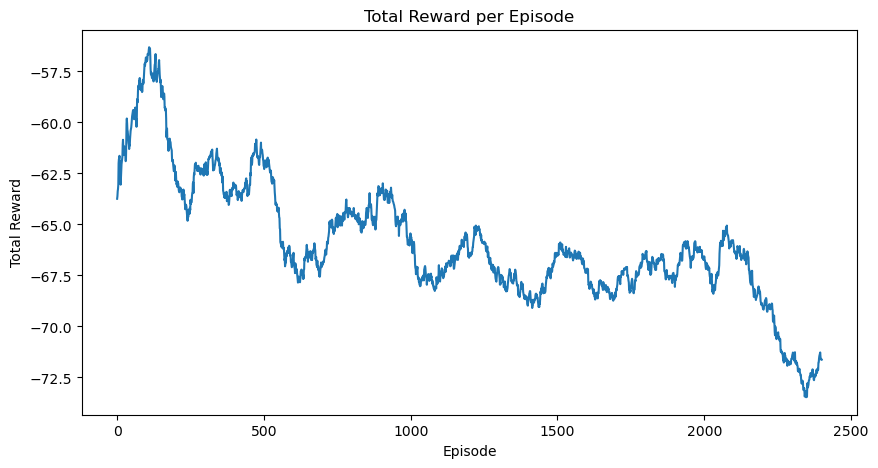

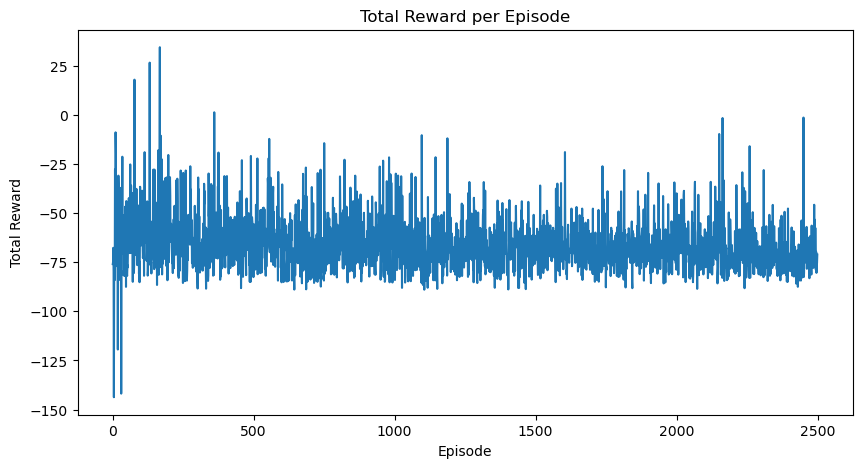

In [20]:
import gymnasium as gym
import numpy as np
import cv2
from collections import deque
import matplotlib.pyplot as plt
import os
from itertools import product
from math import floor

# --- DIRECTORY SETUP ---
os.makedirs("plots", exist_ok=True)
os.makedirs('recorded_states', exist_ok=True)

# --- ENV SETUP ---
env = gym.make("CarRacing-v3", continuous=False, render_mode="rgb_array")
CROP_HEIGHT_PERCENTAGE = 0.12
DO_NOTHING, LEFT, RIGHT, GAS, BRAKE = 0, 1, 2, 3, 4

# --- RL PARAMS ---
epsilon = 0.1
gamma = 0.99
alpha = 0.01
feature_dim = 5
n_actions = env.action_space.n
record_episodes = {10, 100, 1000, 1700, 2000, 2500}
recorded_states = {}

# --- FEATURE FUNCTIONS ---
obs_history = deque(maxlen=5)
speed_history = deque(maxlen=2)

def extract_features(obs, obs_history, speed_history):
    vel_vec = env.unwrapped.car.hull.linearVelocity
    speed = np.linalg.norm([vel_vec.x, vel_vec.y])
    
    # Track acceleration from speed history
    speed_history.append(speed)

    if len(speed_history) == 2:
        # Approximate acceleration (delta_v / delta_t), assuming ~50 FPS → delta_t = 1/50
        acceleration = (speed_history[-1] - speed_history[-2]) * 50.0
        acceleration = np.clip(acceleration / 10.0, -1.0, 1.0)  # Normalize acceleration
    else:
        acceleration = 0.0

    gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    RESIZE_SCALE = 64
    resized = cv2.resize(gray, (RESIZE_SCALE, RESIZE_SCALE))
    
    edges = auto_canny(resized)

    norm = resized / 255.0
    # Track center offset
    half = norm.shape[1]//2
    left_sum, right_sum = np.sum(norm[:, :half]), np.sum(norm[:, half:])
    center_offset = (right_sum - left_sum) / (left_sum + right_sum + 1e-5)
    
    # Curvature
    obs_history.append(norm)
    curvature = np.mean([np.abs(obs_history[i] - obs_history[i-1]).mean() 
                        for i in range(1, len(obs_history))]) if len(obs_history) == obs_history.maxlen else 0.0
    # WE MAY NEED TO CHECK IF THE VALS ARE ACCURATE
    curvature = np.clip(curvature*5.0,0.0,1.0)
    # Lane detection
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 30, minLineLength=20, maxLineGap=10)
    lane_angles = [np.arctan2(y2 - y1, x2 - x1) for line in lines for x1, y1, x2, y2 in [line[0]]] if lines is not None else []
    avg_lane_angle = np.mean(lane_angles) if lane_angles else 0.0
    
    return np.array([
        center_offset,
        curvature,
        avg_lane_angle / np.pi,
        min(speed / 100.0, 1.0),
        acceleration,
    ],dtype=np.float32)

def auto_canny(image, sigma=0.33):
    """Compute Canny edges with thresholds based on image median intensity."""
    v = np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    return cv2.Canny(image, lower, upper)


def select_action(state_features, theta, epsilon=0.1):
    if np.random.rand() < epsilon:
            return np.random.choice(n_actions)
    return np.argmax([
        theta @ tile_coder.get_features(state_features, a)
        for a in range(n_actions)
    ])

def skip_frames(obs, skip=50):
    for _ in range(skip):
        obs, reward, terminated, truncated, _ = env.step(DO_NOTHING)
        if terminated or truncated:
            return obs, terminated, truncated
    return obs, reward, terminated, truncated


class TileCoder:
    def __init__(self, num_tilings, tiles_per_dim, input_dim, n_actions, low, high):
        self.num_tilings = num_tilings
        self.tiles_per_dim = tiles_per_dim
        self.input_dim = input_dim
        self.n_actions = n_actions
        self.low = np.array(low)
        self.high = np.array(high)
        self.tile_width = (self.high - self.low) / (tiles_per_dim - 1)
        self.total_tiles_per_tiling = tiles_per_dim ** input_dim
        self.total_features = self.total_tiles_per_tiling * num_tilings * n_actions

        # Compute tiling offsets to shift each tiling uniquely
        self.offsets = [np.linspace(0, tile_w, num_tilings, endpoint=False)
                        for tile_w in self.tile_width]
        self.offsets = np.stack(self.offsets, axis=1)  # shape: (num_tilings, input_dim)

    def get_features(self, state, action):
        state = np.array(state)
        features = np.zeros(self.total_features, dtype=np.float32)

        for tiling in range(self.num_tilings):
            offset = self.offsets[tiling]
            shifted_state = state + offset
            indices = ((shifted_state - self.low) / self.tile_width).astype(int)
            indices = np.clip(indices, 0, self.tiles_per_dim - 1)

            # Flatten multi-dimensional tile index into a single index
            tile_index = 0
            for i in range(self.input_dim):
                tile_index *= self.tiles_per_dim
                tile_index += indices[i]

            # Compute final feature index
            index = (tiling * self.total_tiles_per_tiling * self.n_actions) + \
                    (tile_index * self.n_actions) + action
            features[index] = 1.0

        return features


# --- TRAINING LOOP ---
episodes = 1
max_episodes = 2500
rewards_history = []
tile_coder = TileCoder( 
    num_tilings=8,
    tiles_per_dim=8,
    input_dim=5,
    n_actions=5,
    low=[-1.0, 0.0, -1.0, 0.0, -1.0],
    high=[1.0, 1.0, 1.0, 1.0, 1.0]
)
theta = np.zeros(tile_coder.total_features)
while episodes <= max_episodes:
    obs, _ = env.reset()
    obs = obs[:int(obs.shape[0] * (1 - CROP_HEIGHT_PERCENTAGE)), :, :]
    obs_history.clear()
    speed_history.clear()

    features = extract_features(obs, obs_history, speed_history)
    phi = features
    assert phi.shape == (feature_dim,)
    action = select_action(phi, theta, epsilon)
    total_reward = 0
    done = False
    
    # Skip initial frames
    obs, reward, terminated, truncated = skip_frames(obs)
    
    if episodes in record_episodes:
        recorded_states[episodes] = {
            'observations': [],
            'features': [],
            'actions': [],
            'rewards': []
        }

    while not done:
        obs_next, reward, terminated, truncated, _ = env.step(action)
        obs_next = obs_next[:int(obs_next.shape[0] * (1 - CROP_HEIGHT_PERCENTAGE)), :, :]
        done = terminated or truncated
        
        features_next = extract_features(obs_next, obs_history, speed_history)
        phi_next = features_next
        assert phi_next.shape == (feature_dim,)
        action_next = select_action(phi_next, theta, epsilon)
        
        if episodes in record_episodes:
                    recorded_states[episodes]['observations'].append(obs_next)
                    recorded_states[episodes]['features'].append(features_next)
                    recorded_states[episodes]['actions'].append(action)
                    recorded_states[episodes]['rewards'].append(reward)
            

        phi = tile_coder.get_features(features, action)

        # Compute max_a' Q(s', a') using tile-coded features
        q_next_values = [theta @ tile_coder.get_features(features_next, a) for a in range(n_actions)]
        q_next = max(q_next_values)

        q_sa = theta @ phi
        td_error = reward + gamma * q_next - q_sa
        theta += alpha * td_error * phi

        # Transition
        action = action_next
        total_reward += reward
        
    print(f"[Episode {episodes}] Total reward: {total_reward:.2f}")
    rewards_history.append(total_reward)
    episodes += 1

env.close()

# Save the recorded states
for episode, data in recorded_states.items():
    np.save(f'recorded_states/episode_{episode}_observations.npy', np.array(data['observations']))
    np.save(f'recorded_states/episode_{episode}_features.npy', np.array(data['features']))
    np.save(f'recorded_states/episode_{episode}_actions.npy', np.array(data['actions']))
    np.save(f'recorded_states/episode_{episode}_rewards.npy', np.array(data['rewards']))

# Plot the smoothed rewards
smoothing_window = 100
smoothed_rewards = np.convolve(rewards_history, np.ones(smoothing_window)/smoothing_window, mode='valid')
plt.figure(figsize=(10, 5))
plt.plot(smoothed_rewards)
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.savefig('plots/smoothed_rewards.png')
plt.show()

# Plot the rewards
plt.figure(figsize=(10, 5))
plt.plot(rewards_history)
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.savefig('plots/rewards.png')
plt.show()
